In [91]:
import requests
import json
from contextlib import closing

# get API key for newsapi.org
APIKEY_FILE = '../newsapi_key.txt'

def read_api_key(api_key_fname):
    """
        read in api key from file. relative path, file just contains api key. return key as string
    """
    with open(api_key_fname) as f:
        api_key = f.read()
    
    return api_key

api_key = read_api_key(APIKEY_FILE)

In [92]:
def get_news_source_name_id_map(api_key):
    # Get news source id : name map
    # parameter api key
    url_template = "https://newsapi.org/v2/sources?apiKey=%s"
    
    # create get request url for news source names and ids
    rurl = url_template % api_key
    
    # make request
    with closing(requests.get(rurl)) as r:
        response = r.json()

    # make sure results were returned
    assert response['status'] == 'ok'
    
    # create python dictonary key: news source name, value: news source id (used in request for articles)
    name_id_map = {}
    sources = response['sources']
    for s in sources:
        name_id_map[s['name']] = s['id']
    
    return name_id_map
    
#get_news_source_name_id_map(api_key)

In [93]:
# or by using python package
#--> pip install newsapi-python
from newsapi import NewsApiClient

# Init
newsapi = NewsApiClient(api_key=api_key)

# get sources
sources = newsapi.get_sources()

In [94]:
# get list news source ids, which can be used for the article get requests
news_sources_ids = list(get_news_source_name_id_map(api_key).values())
print(news_sources_ids)

['abc-news', 'abc-news-au', 'aftenposten', 'al-jazeera-english', 'ansa', 'argaam', 'ars-technica', 'ary-news', 'associated-press', 'australian-financial-review', 'axios', 'bbc-news', 'bbc-sport', 'bild', 'blasting-news-br', 'bleacher-report', 'bloomberg', 'breitbart-news', 'business-insider', 'business-insider-uk', 'buzzfeed', 'cbc-news', 'cbs-news', 'cnbc', 'cnn', 'cnn-es', 'crypto-coins-news', 'daily-mail', 'der-tagesspiegel', 'die-zeit', 'el-mundo', 'engadget', 'entertainment-weekly', 'espn', 'espn-cric-info', 'financial-post', 'financial-times', 'focus', 'football-italia', 'fortune', 'four-four-two', 'fox-news', 'fox-sports', 'globo', 'google-news', 'google-news-ar', 'google-news-au', 'google-news-br', 'google-news-ca', 'google-news-fr', 'google-news-in', 'google-news-is', 'google-news-it', 'google-news-ru', 'google-news-sa', 'google-news-uk', 'goteborgs-posten', 'gruenderszene', 'hacker-news', 'handelsblatt', 'ign', 'il-sole-24-ore', 'independent', 'infobae', 'info-money', 'la-gac

In [95]:
"""
Article Scraper from a given url

requirements: 
	-Newspaper3k, https://github.com/codelucas/newspaper, http://newspaper.readthedocs.io/en/latest/, https://newsapi.org/docs/client-libraries/python
    --> pip install newspaper3k
Notes: 	
	newspaper offers nlp summary
	article.nlp()
	print(article.summary)

"""
# external
from newspaper import Article

def get_full_article(url):
    # does not work for video news sources etc
    article = Article(url)
    article.download()
    article.parse()
    text = article.text
    if len(text) < 10:
        #print("warning with article url when extracting full text. Function: get_full_article")
        return None
    return text

# testing
test_article_url = "http://www.foxnews.com/world/2018/08/28/likely-lula-replacement-denies-corruption-charges-in-brazil.html"
print(get_full_article(test_article_url))

next

prev

The man in line to replace jailed presidential candidate Luiz Inacio Lula da Silva as the Brazilian Workers' Party standard-bearer on Tuesday denied accusations of corruption.

Prosecutors accuse Fernando Haddad of receiving indirect payments to his 2012 campaign for Sao Paulo mayor.

Construction company UTC Engenharia got preferential treatment on bids after covering about US$1.6 million of debt associated with Haddad's campaign, according to a former accusation filed Monday. Although Haddad did not request payment directly, he had full control over the scheme, according to prosecutors.

On Tuesday, Haddad responded while campaigning in Rio de Janeiro. He said that he cancelled a multimillion dollar project with a company belonging to the UTC group after an employee alerted him that the company was overcharging the government.

"How is it that a mayor who cancels a corrupt construction project gets put through this instead of being thanked for saving the city tens of mill

In [96]:
# example selected news sources ids
selected_news_sources_ids = ["fox-news", "msnbc.com", "vice-news", "cnn", "bbc-news", "breitbart-news", "the-huffington-post", "the-new-york-times"]

# generate a get request url for given news source for newsapi.org
def generate_articles_get_request_url(news_source_id, api_key):
    """ 
        ex: https://newsapi.org/v2/everything?sources=fox-news,msnbc.com&apiKey=f86cb840aef7406cbf34bc6d78d31297
        :param news_sources: list of strings to include into formatted get request
        :param api_key: string api key for newsapi.org
        :returns: string, get request url
    """
    # first %s : comma seperated news sources
    # second %s : api key string
    url_template = "https://newsapi.org/v2/everything?sources=%s&apiKey=%s"
    
    return url_template % (news_source_id, api_key)

# make request for articles from selected news source
def news_api_response_articles(news_source_id, api_key):
    # generate request url using news source id and api key
    rurl = generate_articles_get_request_url(news_source_id, api_key)

    # make request
    with closing(requests.get(rurl)) as r:
        response = r.json()

    # make sure results were returned
    assert response['status'] == 'ok'
    
    return response
    

# get list of article objects from response from newsapi.org
def get_list_of_article_objects(response, include_full_articles=True):
    
    # get array of article json objects/list
    articles = response['articles']
    
    # for article in articles look at 'source', 'title', 'description', 'url'
    # extract article sources titles descriptions and links to urls of actual articles
    article_objects = []
    for a in articles:
        #news_source_name = a['source']['name']
        
        # attempt to get full article text using t using Newspaper3k
        #text = get_full_article(a['url'])
        
        article_object = {
            'news_source_id' : a['source']['id'], # article news source id
            'title' : a['title'], # article title 
            'description' : a['description'], # breif article description
            'url' : a['url'], # full article url
        }
        
        if include_full_articles:
            article_object['text'] = get_full_article(a['url']) # get full article text using Newspaper3k -- often None
        
        article_objects.append(article_object)
        
    return article_objects



# get article description objects from source test
selected_source_id = selected_news_sources_ids[0]
print(selected_source_id)
response = news_api_response_articles(selected_source_id, api_key)
source_article_objects = get_list_of_article_objects(response)
print(source_article_objects)



fox-news
[{'news_source_id': 'fox-news', 'title': 'Marines 3D-print concrete barracks in just 40 hours', 'description': 'Marines have used a specialized 3D concrete printer to print a 500-square-foot barracks room in just 40 hours.', 'url': 'http://www.foxnews.com/tech/2018/08/29/marines-3d-print-concrete-barracks-in-just-40-hours.html', 'text': "Marines have used a specialized 3D concrete printer to print a 500-square-foot barracks room in just 40 hours.\n\nThe innovative project created the world’s first continuous 3D-printed concrete barracks, according to the Marine Corps.\n\nThe barracks room was built earlier this month at the U.S. Army Engineer Research and Development Center in Champaign, Illinois. Army and Navy Seabees were also involved in the construction effort.\n\nGOOGLE LAUNCHES NEW SEARCH TOOL TO HELP VETERANS GET CIVILIAN JOBS\n\nHarnessing the world’s largest concrete printer, the Additive Manufacturing Team at Marine Corps Systems Command teamed up with Marines from I

In [121]:
# or by using python package
# -- https://github.com/mattlisiv/newsapi-python
#--> pip install newsapi-python
#from newsapi import NewsApiClient

def get_all_articles(source_id, api_key, max_articles=500, include_full_article_text=True):
    
    # init
    newsapi = NewsApiClient(api_key=api_key)
    
    # get all articles incrementing page number
    #total_results = response['totalResults']
    
    all_article_objects = []
    page_number = 1
    
    while len(all_article_objects) < max_articles:
        page_number = page_number + 1
        response = newsapi.get_everything(sources=selected_source_id,
                                      language='en',
                                      page=page_number, # can also use dates
                                        page_size=25) # 100 is maximum page size
    
        assert response['status'] == 'ok'
        all_article_objects += get_list_of_article_objects(response, include_full_articles=include_full_article_text)
        print("number of articles collected: %s" % len(all_article_objects))
        
    return all_article_objects
        

# number of documents
num_documents = 50

# example -- set include full article text to True for scrapping the actual site
all_article_objects = get_all_articles(selected_source_id, api_key, max_articles=num_documents, include_full_article_text=False)

print(len(all_article_objects))
print(all_article_objects)

number of articles collected: 25
number of articles collected: 50
50
[{'news_source_id': 'fox-news', 'title': "California boy refuses to hit bullies because 'it's not the Jedi way' - Fox News", 'description': "Fox News California boy refuses to hit bullies because 'it's not the Jedi way' Fox News A California fifth-grader had to be hospitalized this week after he refused to fight back against a bully at school. Why? “It's not the Jedi way,” said 10-year-old Aiden V…", 'url': 'http://www.foxnews.com/lifestyle/2018/08/29/california-boy-refuses-to-hit-bullies-its-not-jedi-way.html'}, {'news_source_id': 'fox-news', 'title': 'Bob Hugin: People of New Jersey deserve better', 'description': 'First-time political candidate, former Marine aims to unseat Menendez in New Jersey Senate bid. Republican candidate says Bob Menendez failed New Jersey morally.', 'url': 'http://video.foxnews.com/v/5828292174001/'}, {'news_source_id': 'fox-news', 'title': "Trump rips CNN over debunked Trump Tower story: 

In [98]:
# get the summary text from each article
#  lead_paragraph  is no snippet
summary_text = [x['title'] for x in all_article_objects]
summary_text

['Hurricane Maria killed 2,975 in Puerto Rico',
 "Iran's supreme leader says government should 'give up hope' on Europe to save nuclear deal",
 'Britons sent abroad as children sue government over abuse',
 'Ron DeSantis on the path forward after his primary victory',
 'Texas company to send blueprints for 3D-printed guns',
 'Morocco shaken by harrowing account of tortured teen',
 'California becomes first state to eliminate cash bail',
 'Should Mueller interview Bruce Ohr?',
 'Truck carrying candy flips on New Jersey highway in apparent road-rage crash - Fox News',
 'Pakistan Islamists rally against anti-Islam cartoon contest',
 'John McCain to lie in state at Arizona Capitol',
 "Ex-Trump attorney on Lanny Davis' 'despicable' behavior",
 'Indian Supreme Court orders house arrest for activists - Fox News',
 'Germany returns 27 sets of colonial-era remains to Namibians',
 'US Open official draws ire after penalizing female player who fixed shirt mid-match - Fox News',
 'Mike Rowe on disc

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() # an object capable of counting words in a document!

# count_vect.fit(summary_text)
# count_vect.transform(summary_text)
bag_words = count_vect.fit_transform(summary_text)

In [100]:
bag_words.shape

(50, 370)

In [101]:
print(len(count_vect.vocabulary_))
print(count_vect.vocabulary_)


370
{'hurricane': 160, 'maria': 201, 'killed': 185, '975': 7, 'in': 165, 'puerto': 261, 'rico': 276, 'iran': 170, 'supreme': 313, 'leader': 191, 'says': 286, 'government': 145, 'should': 302, 'give': 143, 'up': 342, 'hope': 158, 'on': 234, 'europe': 112, 'to': 328, 'save': 285, 'nuclear': 229, 'deal': 90, 'britons': 44, 'sent': 291, 'abroad': 10, 'as': 28, 'children': 62, 'sue': 312, 'over': 241, 'abuse': 11, 'ron': 279, 'desantis': 94, 'the': 323, 'path': 245, 'forward': 135, 'after': 15, 'his': 155, 'primary': 258, 'victory': 346, 'texas': 321, 'company': 72, 'send': 289, 'blueprints': 40, 'for': 133, '3d': 6, 'printed': 259, 'guns': 148, 'morocco': 213, 'shaken': 298, 'by': 47, 'harrowing': 150, 'account': 13, 'of': 231, 'tortured': 329, 'teen': 318, 'california': 49, 'becomes': 35, 'first': 126, 'state': 308, 'eliminate': 106, 'cash': 61, 'bail': 33, 'mueller': 214, 'interview': 168, 'bruce': 45, 'ohr': 233, 'truck': 338, 'carrying': 57, 'candy': 54, 'flips': 129, 'new': 221, 'jers

In [102]:
# now let's create a pandas API out of this
import pandas as pd

pd.options.display.max_columns = 999
df = pd.DataFrame(data=bag_words.toarray(),columns=count_vect.get_feature_names())

In [134]:
# get the summary text from each article
#  lead_paragraph  is no snippet
count_words = lambda text: len(text.split(' '))

words_per_document = [count_words(x['description']) for x in all_article_objects]

In [137]:
df_words_per_document = pd.DataFrame(data=words_per_document, columns=['length'])
df_words_per_document.index.name = 'id'
df_words_per_document

,length
id,
0,46
1,23
2,45
3,18
4,38
5,36
6,31
7,23
8,43


In [103]:
bag_words.toarray()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [104]:
import numpy as np
m=bag_words.toarray()
np.count_nonzero(m)

508

In [105]:
# print out 10 most common words in our data
df.sum().sort_values()[-20:]

florida     3
arrest      3
us          3
that        3
primary     3
his         3
says        3
killed      3
over        3
life        3
the         4
up          4
trump       5
for         6
of          8
on          9
in         12
to         12
news       17
fox        17
dtype: int64

In [106]:
# print out 10 least common words in our data
df.sum().sort_values()[-10:] # small sample size means most words occur one time

the       4
up        4
trump     5
for       6
of        8
on        9
in       12
to       12
news     17
fox      17
dtype: int64

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer() # an object capable of counting words in a document!

tfidf_mat = tfidf_vect.fit_transform(summary_text) # that's it! its converted!!

In [108]:
# convert to pandas to get better idea about the data
df_tfidf = pd.DataFrame(data=tfidf_mat.toarray(),columns=tfidf_vect.get_feature_names())
#df

In [109]:
# print out 10 words with max tfidf, normalized by document occurrence
df_tfidf.max().sort_values()[-10:]

two          0.431610
extreme      0.434041
relief       0.434041
this         0.434041
week         0.434041
day          0.452615
rich         0.452615
mueller      0.473859
interview    0.473859
in           0.498322
dtype: float64

In [111]:
# now lets do the transformation with a smaller vocabulary
tfidf_vect = TfidfVectorizer(stop_words='english',
                             max_df=0.4,
                             min_df=0.001)
news_tfidf = tfidf_vect.fit_transform(summary_text) 
print(news_tfidf.shape)
vec=news_tfidf.max(axis=0)
df_tfidf_reduced = pd.DataFrame(data=vec.toarray(),columns=tfidf_vect.get_feature_names())
df_tfidf_reduced.max().sort_values()[-10:]

(50, 321)


travel         0.500000
cool           0.500000
gadgets        0.500000
trip           0.500000
collapse       0.519100
scaffolding    0.519100
mueller        0.524455
interview      0.524455
day            0.533190
rich           0.533190
dtype: float64

In [112]:
# this python magics will allow plot to be embedded into the notebook
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 


In [113]:
df_tfidf_reduced.describe

<bound method NDFrame.describe of          11       160        18       1st        27        29        3d  \
0  0.357649  0.353381  0.377964  0.357649  0.357649  0.447214  0.388202   

        975    aboard    abroad     abuse  accident   account  activists  \
0  0.418866  0.377964  0.388202  0.351067  0.401936  0.408248   0.382762   

     agents   angeles      anti  apparent  appearance   ariana   arizona  \
0  0.353381  0.408248  0.377964  0.295009    0.357649  0.30875  0.387253   

     arrest  attempts  attorney    august      bail    battle  behavior  \
0  0.327454  0.408248  0.388826  0.447214  0.464455  0.272634  0.388826   

   billowing  blueprints  bombshell    border       boy   britons     bruce  \
0   0.377964    0.388202   0.357649  0.311466  0.377964  0.388202  0.474286   

      calif  california     calls  campaign   canada  candidates     candy  \
0  0.382981    0.420026  0.343194  0.382981  0.45559    0.409969  0.295009   

        cap   capitol  carrying      cars 

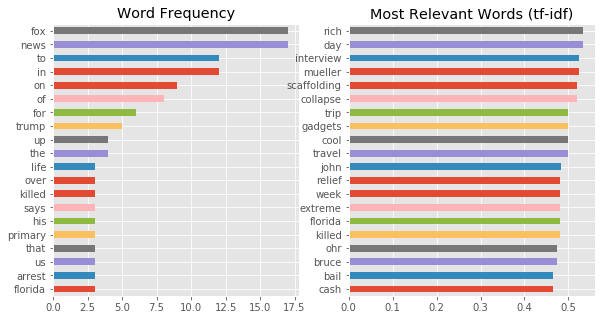

In [120]:
# Start by just plotting what we previously grouped!
Top20words=df.sum().sort_values()[-20:]
Top20relvantwords = df_tfidf_reduced.max().sort_values()[-20:]

plt.style.use('ggplot')

fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
Top20words.plot(kind='barh')
plt.title('Word Frequency')

plt.subplot(1,3,2)
Top20relvantwords.plot(kind='barh')

#plt.subplot(1,3,3)
#df_imputed.Age.plot.hist(bins=20, )
#df_imputed.Age.plot.kde(bw_method=0.1, secondary_y=True)
plt.title('Most Relevant Words (tf-idf)')

plt.show()

In [ ]:
"""
	NLP Summary
"""


#
#	Processing Methods
#

def processes_and_tokenize(raw_document):
	""" remove punctuation, convert to lower case, and return list of tokens """
	logger.info('Cleaning Text')

	tokenizer = RegexpTokenizer(r'\w+')
	tokens = tokenizer.tokenize(raw_document.lower())		# tokens = nltk.word_tokenize(corpus.lower()) # without removing punctiation

	#remove stop words
	stop_words = set(stopwords.words('english'))
	filtered_tokens = [w for w in tokens if not w in stop_words]

	logger.info('Cleaning Text Complete')
	return filtered_tokens
